 ## Frequency domain exploration

In [21]:
import neo
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.fft import fft, fftfreq
import bokeh
from scipy.stats import ks_2samp
from scipy.signal import welch


In [2]:
# List of filenames for each eye
filenames = [
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms003.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms002.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms018.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms011.ns5"
]

# Initialize an empty list to hold the data from all eyes
all_data = []

# Loop through each file and read the data
for filename in filenames:
    reader = neo.io.BlackrockIO(filename=filename)
    
    # Read the data from the file
    block_SA = reader.read_block()
    
    # Access the first segment
    segment_SA = block_SA.segments[0]
    
    # Access the first analog signal within this segment
    analog_signal_SA = segment_SA.analogsignals[0]
    
    # Access the signal data as a NumPy array and append it to the list
    data_SA = np.asarray(analog_signal_SA.magnitude)
    all_data.append(data_SA)

# Print shape of the data
print(f"Data shape: {np.shape(all_data)}")


Data shape: (6, 300300, 32)


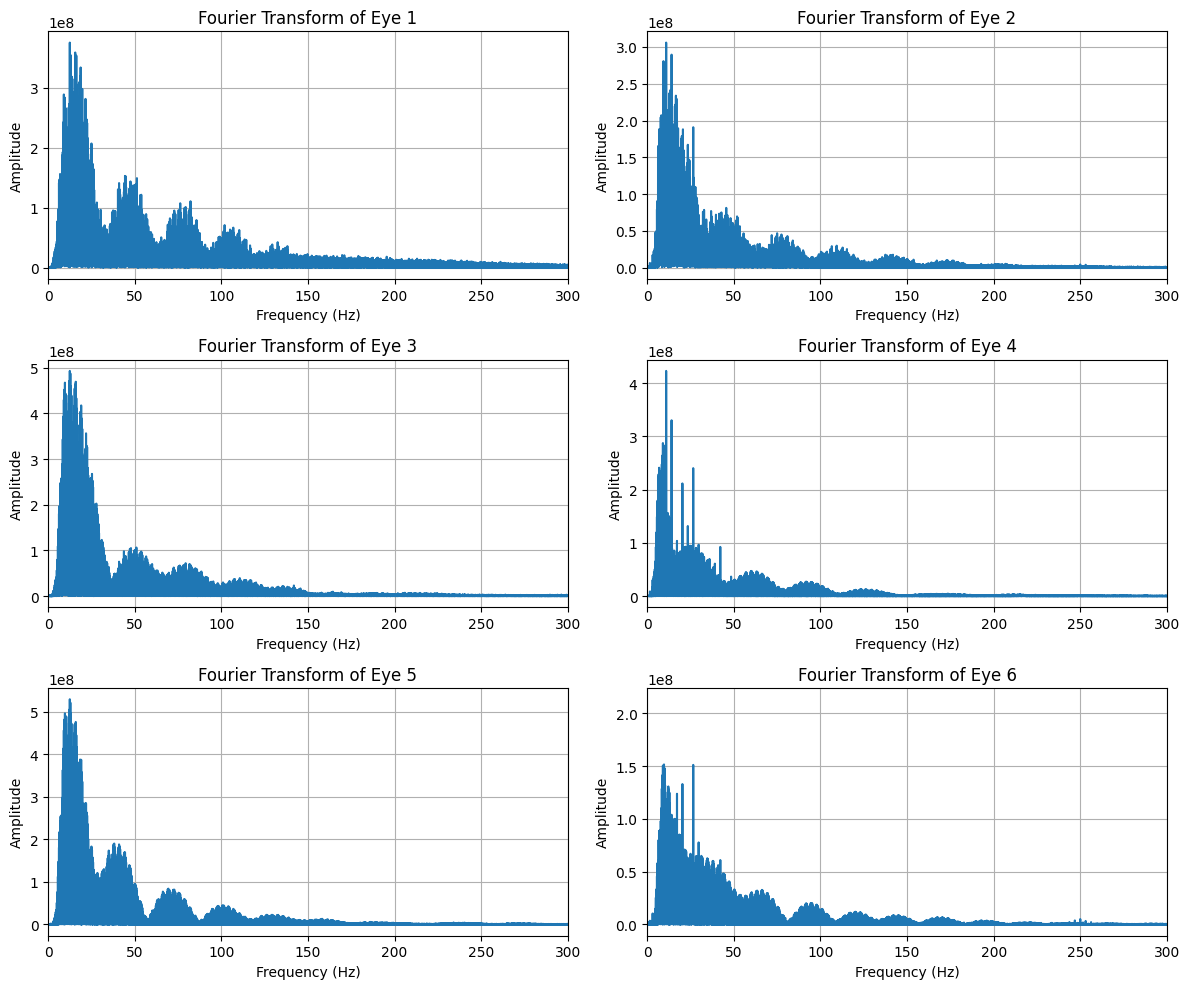

Fourier data shape: (6, 2, 9609600)


In [20]:
sampling_rate = 30000  # Hz
fourier_data = []
power_spectra = []


# Set up a 3x2 grid for plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the 2D array of axes to iterate over

# Define the frequency range you want to zoom into
zoom_min_freq = 0  # Minimum frequency to display (in Hz)
zoom_max_freq = 300  # Maximum frequency to display (in Hz)

# Loop through each file, read the data, perform Fourier transform, and plot
for i, data_eye in enumerate(all_data):
    # Apply Fourier Transform on the data
    N = len(data_eye)  # Number of samples in the data
    yf = fft(data_eye)  # Perform FFT
    xf = fftfreq(N, 1 / sampling_rate)  # Frequency axis
    
    # Save Fourier transform data
    fourier_data.append((xf, yf))  # Store both frequency and transformed data

    # Compute Power Spectrum (squared magnitude of Fourier coefficients)
    power_spectrum = np.abs(yf[:N // 2]) ** 2
    power_spectra.append(power_spectrum)

    # Plot the Fourier Transform on the 3x2 grid
    axes[i].plot(xf[:N // 2], np.abs(yf[:N // 2]))  # Plot positive frequencies only
    axes[i].set_title(f"Fourier Transform of Eye {i+1}")
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

    # Zoom in by setting x-axis limits to focus on the desired frequency range
    axes[i].set_xlim([zoom_min_freq, zoom_max_freq])

# Adjust layout for clarity and save the figure
plt.tight_layout()
plt.show()

# Print shape of the Fourier transform data
print(f"Fourier data shape: {np.shape(fourier_data)}")



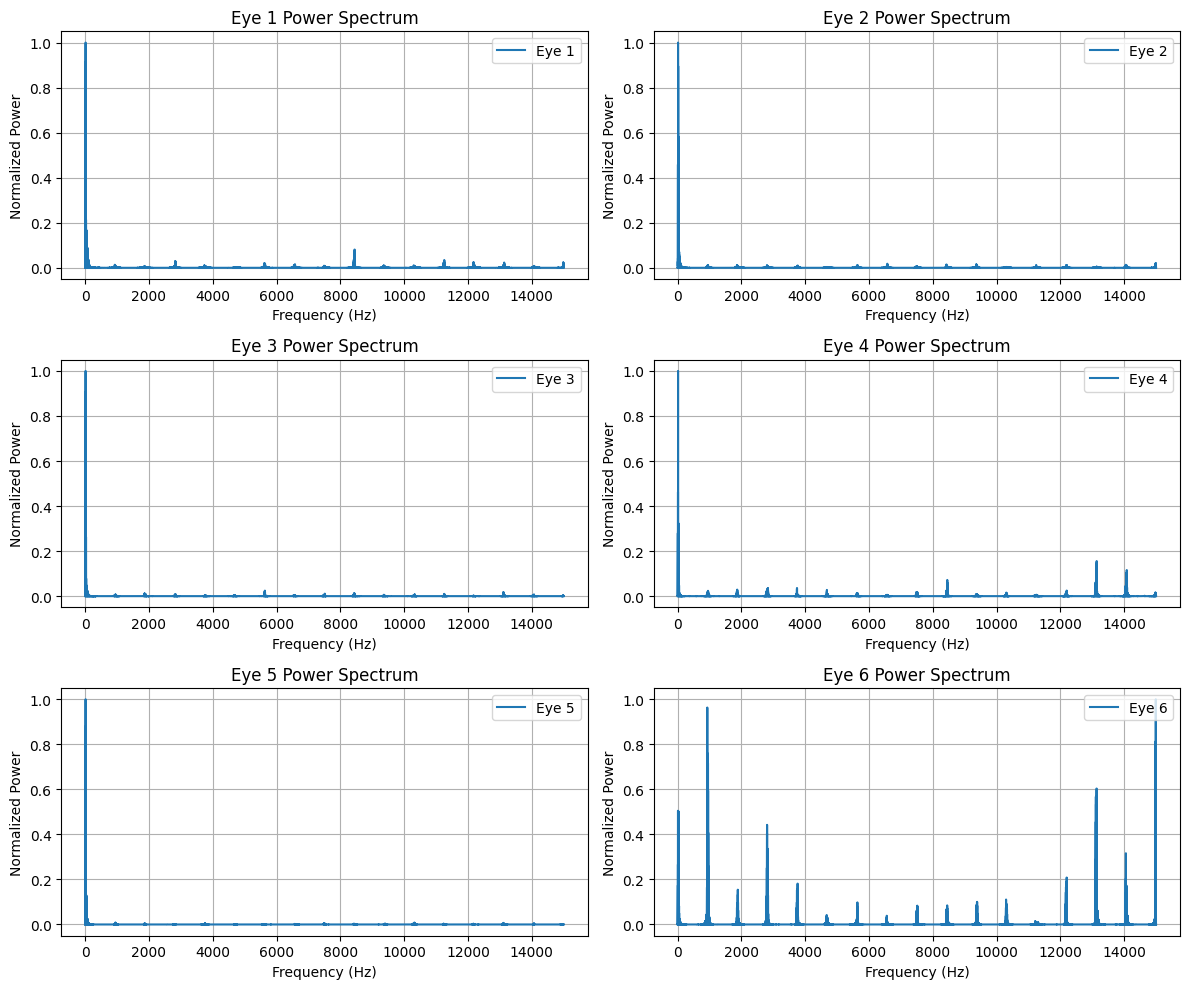

In [18]:
# Convert power spectra to NumPy array for easier manipulation
power_spectra = np.array(power_spectra)

# Normalize the power spectra for comparison (optional)
normalized_power_spectra = power_spectra / np.max(power_spectra, axis=1, keepdims=True)

# Plot all normalized power spectra to visually compare across eyes
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()  

for i in range(len(filenames)):
    axes[i].plot(xf[:N // 2], normalized_power_spectra[i], label=f'Eye {i+1}')
    axes[i].set_title(f'Eye {i+1} Power Spectrum')
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Normalized Power")
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

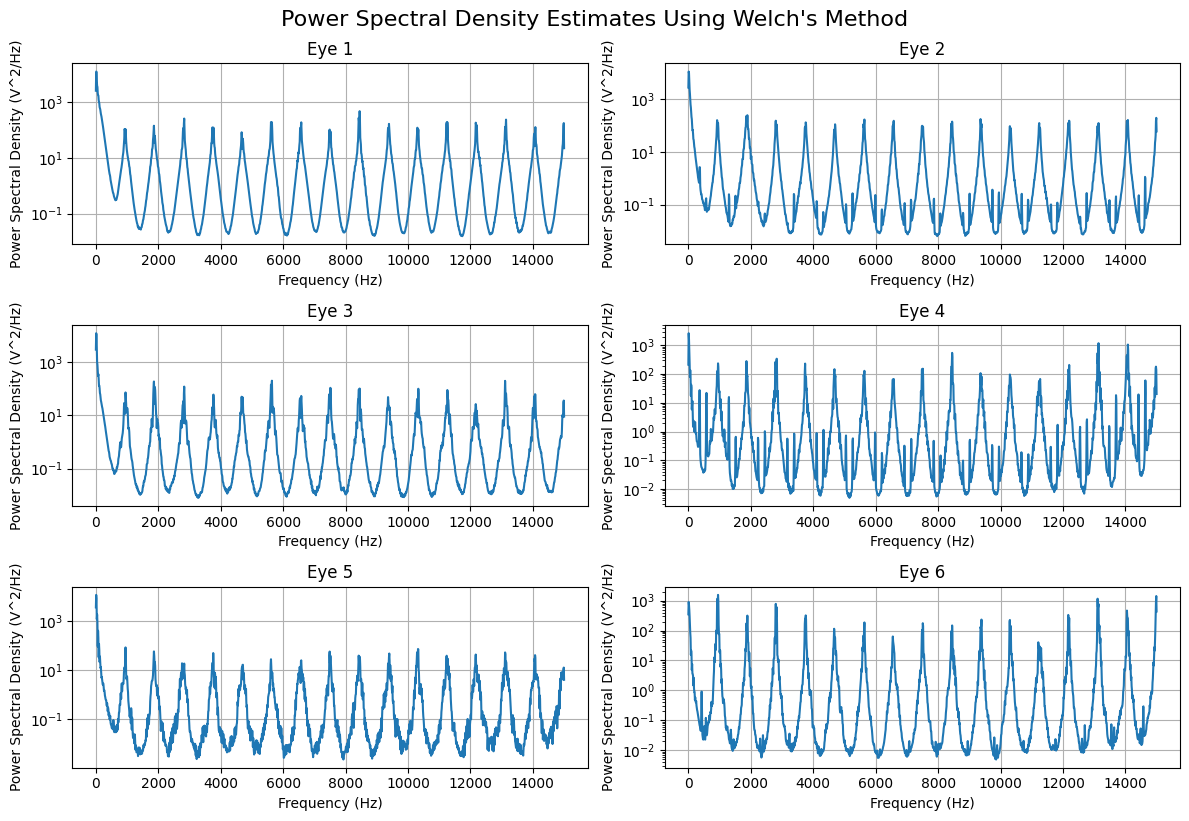

In [22]:
# Parameters for Welch's method
fs = 30000  # Sampling frequency (Hz)
nperseg = 3000 # Length of each segment
noverlap = nperseg // 2  # Overlap between segments

# Initialize an array to hold the power spectral density for each eye
psd_results = []

# Apply Welch's method to each channel's data
for eye_data in all_data:
    f, Pxx = welch(eye_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    psd_results.append((f, Pxx))

# Plot the results in a 3x2 grid
plt.figure(figsize=(12, 8))
for i, (f, Pxx) in enumerate(psd_results):
    plt.subplot(3, 2, i + 1)
    plt.semilogy(f, Pxx)  # Use a logarithmic scale for better visualization
    plt.title(f'Eye {i + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V^2/Hz)')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Power Spectral Density Estimates Using Welch\'s Method', fontsize=16, y=1.02)
plt.show()
